In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import random
import importlib
import mpt_functions as mpt
importlib.reload(mpt)

<module 'mpt_functions' from 'd:\\Code\\Graduation-Project\\mpt_functions.py'>

In [7]:
path = "C:/Users/bilge/Downloads/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)
df = mpt.drop_a_column(df, "Unnamed: 0")
df.head()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [8]:
df_day1 = mpt.filter_a_day("2020-02-15",df)
df_day1

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,2020-02-15 00:00:07,-0.010,9.742,9.726,-0.018,9.742,60.775,3.9675,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2020-02-15 00:00:17,-0.010,9.728,9.712,-0.018,9.728,60.600,3.9200,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,2020-02-15 00:00:26,-0.010,9.716,9.698,-0.018,9.716,60.400,3.9275,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,2020-02-15 00:00:36,-0.008,9.702,9.686,-0.018,9.702,60.200,3.9250,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,2020-02-15 00:00:46,-0.008,9.690,9.674,-0.018,9.690,59.975,3.9275,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8711,2020-02-15 23:59:17,9.520,9.204,-0.014,-0.020,9.202,48.575,6.0050,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
8712,2020-02-15 23:59:27,9.750,9.442,-0.012,-0.020,9.438,48.725,6.1050,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
8713,2020-02-15 23:59:36,9.940,9.556,-0.012,-0.022,9.554,49.125,6.1075,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
8714,2020-02-15 23:59:46,10.154,9.780,-0.012,-0.020,9.774,49.675,6.2475,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [9]:
df_day1 = mpt.aggregate_as_a_minute(df_day1)
df_day1

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,2020-02-15 00:00:00,-0.009333,9.709000,9.692333,-0.018000,9.709000,60.325000,3.929583,1.000000,0.000000,1.0,1.000000,0.0,1.0,1.0,1.0
1,2020-02-15 00:01:00,-0.008333,9.632333,9.616333,-0.018333,9.634333,59.637500,3.915417,1.000000,0.000000,1.0,1.000000,0.0,1.0,1.0,1.0
2,2020-02-15 00:02:00,-0.009000,9.559667,9.543000,-0.018000,9.561333,59.416667,3.956250,1.000000,0.000000,1.0,1.000000,0.0,1.0,1.0,1.0
3,2020-02-15 00:03:00,-0.009333,9.489333,9.473333,-0.018333,9.491667,59.562500,3.950000,1.000000,0.000000,1.0,1.000000,0.0,1.0,1.0,1.0
4,2020-02-15 00:04:00,-0.009000,9.420333,9.404667,-0.018667,9.423667,59.650000,0.039167,1.000000,0.000000,1.0,1.000000,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2020-02-15 23:55:00,-0.011667,8.150333,8.136333,-0.021667,8.151000,48.816667,0.038750,1.000000,0.000000,1.0,1.000000,0.0,1.0,1.0,1.0
1436,2020-02-15 23:56:00,-0.013333,8.116333,8.103667,-0.021333,8.116667,48.708333,0.038333,1.000000,0.000000,1.0,1.000000,0.0,1.0,1.0,1.0
1437,2020-02-15 23:57:00,-0.012333,8.084667,8.071667,-0.021000,8.086000,48.537500,0.038333,1.000000,0.000000,1.0,1.000000,0.0,1.0,1.0,1.0
1438,2020-02-15 23:58:00,5.303667,8.245333,2.668333,-0.020667,8.244667,48.383333,3.860417,0.333333,0.666667,0.5,0.333333,0.0,1.0,1.0,1.0


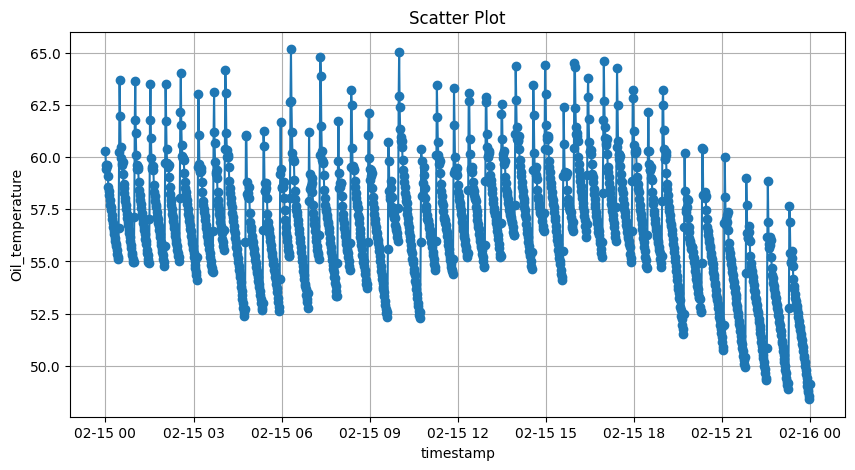

In [10]:
mpt.plot_columns(df_day1,"timestamp", "Oil_temperature")

In [11]:
df_oil_temp = df_day1[["timestamp",'Oil_temperature']]
df_oil_temp.head()

,timestamp,Oil_temperature
0,2020-02-15 00:00:00,60.325000
1,2020-02-15 00:01:00,59.637500
2,2020-02-15 00:02:00,59.416667
3,2020-02-15 00:03:00,59.562500
4,2020-02-15 00:04:00,59.650000


In [12]:
print(df_oil_temp['Oil_temperature'].isna().sum())  # Count NaN values
print((df_oil_temp['Oil_temperature'] == float('inf')).sum())  # Count positive infinity
print((df_oil_temp['Oil_temperature'] == float('-inf')).sum())  # Count negative infinity

0
0
0


In [13]:
# Augmented Dickey-Fuller test for stationarity
adf_test = adfuller(df_oil_temp['Oil_temperature'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("Data is non-stationary. Differencing needed.")
    df_oil_temp_diff = df_oil_temp.diff().dropna()

ADF Statistic: -7.490598193690781
p-value: 4.516366706933471e-11


In [14]:
df_oil_temp.head()

,timestamp,Oil_temperature
0,2020-02-15 00:00:00,60.325000
1,2020-02-15 00:01:00,59.637500
2,2020-02-15 00:02:00,59.416667
3,2020-02-15 00:03:00,59.562500
4,2020-02-15 00:04:00,59.650000


In [15]:
print(df_oil_temp.columns)

Index(['timestamp', 'Oil_temperature'], dtype='object')


In [16]:
df_oil_temp.shape

(1440, 2)

In [17]:
forecast_hour_start = pd.Timestamp("2020-02-15 00:00:00")  # Start of the hour
forecast_hour_end = pd.Timestamp("2020-02-15 12:00:00")    # End of the hour


df_hour = df_oil_temp[(df_oil_temp["timestamp"] >= forecast_hour_start) & (df_oil_temp["timestamp"] < forecast_hour_end)]

print("Hourly Data Shape:", df_hour.shape)
print(df_hour.head(12))

Hourly Data Shape: (720, 2)
             timestamp  Oil_temperature
0  2020-02-15 00:00:00        60.325000
1  2020-02-15 00:01:00        59.637500
2  2020-02-15 00:02:00        59.416667
3  2020-02-15 00:03:00        59.562500
4  2020-02-15 00:04:00        59.650000
5  2020-02-15 00:05:00        59.087500
6  2020-02-15 00:06:00        58.570833
7  2020-02-15 00:07:00        58.375000
8  2020-02-15 00:08:00        58.175000
9  2020-02-15 00:09:00        57.966667
10 2020-02-15 00:10:00        57.725000
11 2020-02-15 00:11:00        57.595833


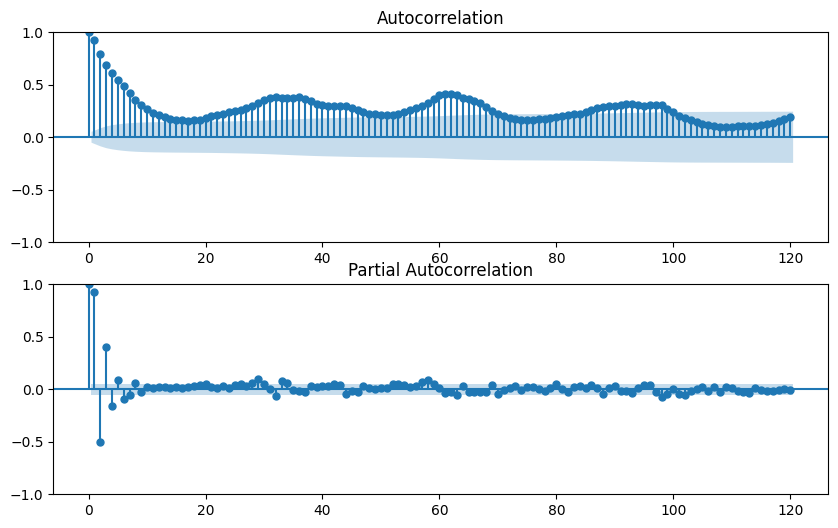

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(df_oil_temp["Oil_temperature"], lags=120, ax=ax[0])  # Shows MA(q)
plot_pacf(df_oil_temp["Oil_temperature"], lags=120, ax=ax[1]) # Shows AR(p)
plt.show()

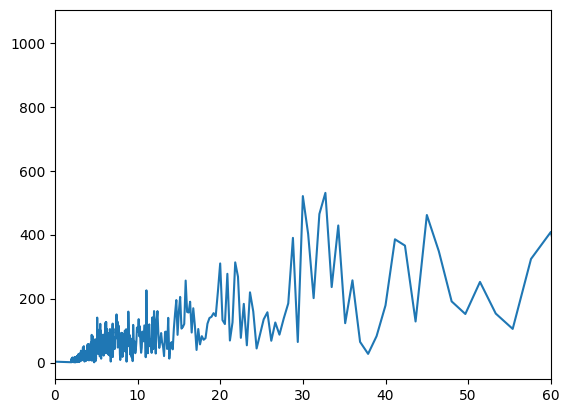

In [30]:
import numpy as np

fft_vals = np.fft.fft(df_oil_temp['Oil_temperature'])
freqs = np.fft.fftfreq(len(fft_vals))

# Avoid division by zero by filtering out zero frequency
nonzero_freqs = freqs[freqs != 0]
nonzero_fft_vals = fft_vals[freqs != 0]

plt.plot(1 / nonzero_freqs, abs(nonzero_fft_vals))  # Period vs. Magnitude
plt.xlim(0, 60)  # Adjust for relevant periods
plt.show()


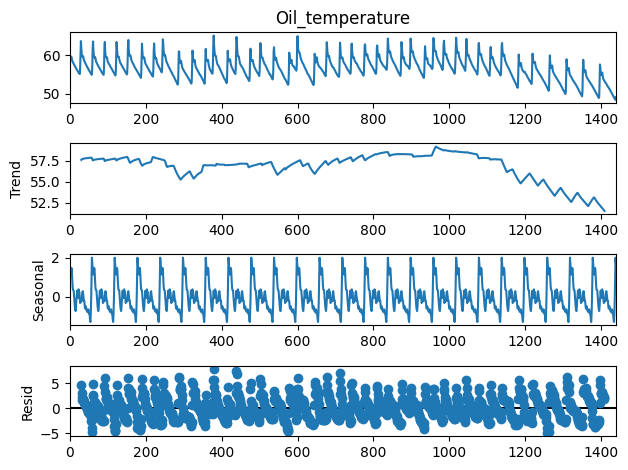

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_oil_temp['Oil_temperature'], period=60, model='additive')  
result.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import kpss

result = kpss(df_oil_temp['Oil_temperature'], regression='c')  # 'c' for constant, 'ct' for trend
print(f"KPSS Test Statistic: {result[0]}")
print(f"p-value: {result[1]}")

KPSS Test Statistic: 1.5062080892140637
p-value: 0.01


d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (example)
model = ARIMA(df_hour['Oil_temperature'], order=(2, 0, 2))  # Replace with your target column
model_fit = model.fit()

# Forecast the next 10 minutes
forecast = model_fit.forecast(steps=10)
print("Forecast for the next 10 minutes:", forecast)

Forecast for the next 10 minutes: 720    58.762008
721    58.304153
722    58.025162
723    57.792531
724    57.625945
725    57.497901
726    57.402739
727    57.330885
728    57.277035
729    57.236535
Name: predicted_mean, dtype: float64


In [ ]:
from pmdarima import auto_arima
auto_arima(df_hour['Oil_temperature']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   64
Model:                        SARIMAX   Log Likelihood                -187.807
Date:                Fri, 21 Mar 2025   AIC                            379.615
Time:                        11:19:40   BIC                            383.932
Sample:                             0   HQIC                           381.316
                                 - 64                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     63.6795      0.625    101.828      0.000      62.454      64.905
sigma2        20.7201      6.249      3.316      0.001       8.472      32.968
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 5.17
Prob(Q):                              0.76   Prob(JB):                         0.08
Heteroskedasticity (H):               1.35   Skew:                             0.38
Prob(H) (two-sided):                  0.49   Kurtosis:                         1.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

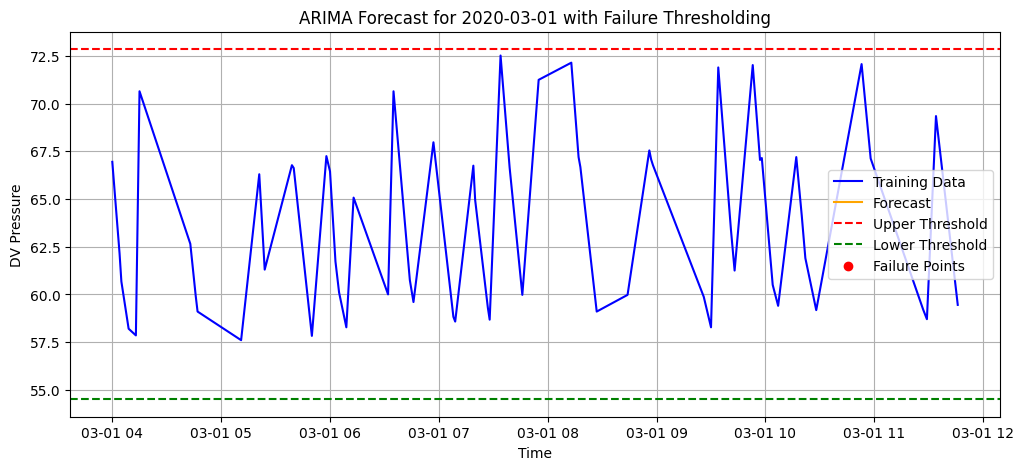

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate thresholds for Oil_temperature
upper_threshold = df_hour['Oil_temperature'].mean() + 2 * df_hour['Oil_temperature'].std()
lower_threshold = df_hour['Oil_temperature'].mean() - 2 * df_hour['Oil_temperature'].std()

forecast_index = pd.date_range(start=df_hour.index[-1] + pd.Timedelta(minutes=1),
                               periods=len(forecast), freq='T')
forecast = pd.Series(forecast, index=forecast_index)

# Identify failure points
failure_points = forecast[(forecast > upper_threshold) | (forecast < lower_threshold)]

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df_hour.index, df_hour['Oil_temperature'], label='Training Data', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='orange')
plt.axhline(upper_threshold, color='red', linestyle='dashed', label='Upper Threshold')
plt.axhline(lower_threshold, color='green', linestyle='dashed', label='Lower Threshold')
plt.scatter(failure_points.index, failure_points, color='red', label='Failure Points', zorder=3)
plt.legend()
plt.title("ARIMA Forecast for 2020-03-01 with Failure Thresholding")
plt.xlabel("Time")
plt.ylabel("DV Pressure")
plt.grid(True)
plt.show()